# WRF plotting example

Adapted from an iPython notebook created by Dan Rothenberg, MIT PAOC

This is a simple example for plotting WRF output using several standard Python libraries:

1. [xarray](http://xarray.pydata.org/en/stable/) - netCDF reading and data manipulation (formerly `xray`; you may want to do `conda remove xray` to remove the old outdated version)
2. [matplotlib](http://matplotlib.org/) - Python basic plotting library

If you're already using Anaconda, then the easiest way to install these will be to simply go to your command line and execute:

```bash
pip install xarray
```

Another library to consider would be [iris](http://scitools.org.uk/iris/docs/latest/index.html) for reading in/handling netCDF data.

We will also use `ipywidgets`

```bash
conda install ipywidgets
```

Any time you update your python packages, you need to restart the python kernel in the *Kernel* menu above.

### Reading in data

Using `xarray`, it's trivial to read in a netCDF dataset. Let's take the first WRF run you did.  Make sure the path is pointing to your run.

In [1]:
%pylab inline
import xarray as xr

dataset = xr.open_dataset("/oasis/scratch/snesbitt/temp_project/WRFV3/test/em_squall2d_x/wrfout_d01_0001-01-01_00:00:00")

Populating the interactive namespace from numpy and matplotlib


Normally, you'd use `ncdump -h squall_slice.nc` from the command line to inspect this file, but we can do something equivalent using xray.

In [2]:
print(dataset)

<xarray.Dataset>
Dimensions:                (Time: 25, bottom_top: 80, bottom_top_stag: 81, soil_layers_stag: 5, south_north: 2, south_north_stag: 3, west_east: 201, west_east_stag: 202)
Coordinates:
    XLONG_V                (Time, south_north_stag, west_east) float32 0.0 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 0.0 ...
    XLAT                   (Time, south_north, west_east) float32 0.0 0.0 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 0.0 ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 0.0 ...
    XTIME                  (Time) datetime64[ns] 2001-01-01 ...
    XLONG                  (Time, south_north, west_east) float32 0.0 0.0 ...
  * Time                   (Time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * bottom_top             (bottom_top) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
  * bottom_top_stag        (bottom_top_stag) int64 0 1 2 3 4 5 6 7 8 9 10 11 ...
  * soil_layers_stag     

We can look into more detail at a given field, too, to see what metadata is attached to it. Note that the default container that `xray` provides, the **Dataset**, implements the standard dictionary interface, so it's easy to grab data fields.

In [3]:
rain = dataset['RAINNC']
print(rain)

<xarray.DataArray 'RAINNC' (Time: 25, south_north: 2, west_east: 201)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       ..., 
       [[ 0.07409398,  0.08390673,  0.10000595, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.07347213,  0.08309811,  0.09888596, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.07409398,  0.08390673,  0.10000595, ...,  0.        ,
          0.        ,  0. 

We can make a simple plot of surface temperature:

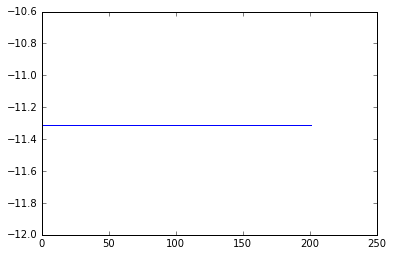

In [4]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(dataset['U'].values[0,0,0,:])


To illustrate simple data manipulation, let's compute total rain accumulation.  We will sum the amount for each model column in the `x` and `y` dimension, and plot against `t`. This will give us an idea of the evolution of the convection in the domain. 

Rather than use giant loops over all the model dimensions, we'll use the convenience tools exposed by `xarray`. See [here](http://xarray.pydata.org/en/stable/data-structures.html) for more details.

In [5]:
total_rain = (rain.load().mean(dim=['south_north'], keep_attrs=True).sum(dim=['west_east'], keep_attrs=True))

Plotting simple data like this is very straightforward, but as a reminder:

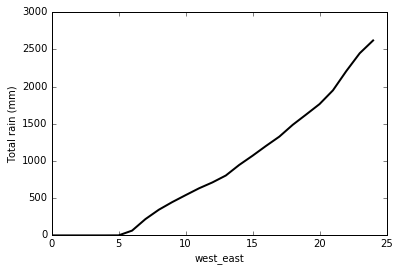

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

lines = ax.plot(total_rain, color='k', lw=2)
ax.set_xlabel('west_east')
ax.set_ylabel("Total rain ({})".format(total_rain.units))

Let's plot a cross section of potential temperature.  WRF stores some variables in its own format, so we must convert them to physical values.  Here are temperature and pressure.

In [7]:
pres = (dataset['P'] + dataset['PB']) * 0.01
pres.attrs['long_name'] = 'Total pressure'
pres.attrs['units'] = 'mb'

temp=dataset['T'] + 300.
temp.attrs['long_name'] = 'Potential Temperature'
temp.attrs['units'] = 'K'

In [8]:
itime=5
temp_slice = (temp.load()
                       .isel(south_north=0,Time=itime,bottom_top=slice(0,40))
                       .squeeze())

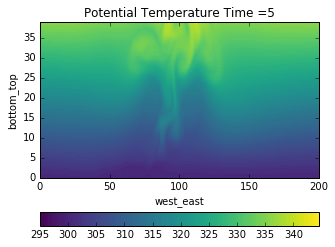

In [9]:
from matplotlib.colors import BoundaryNorm

levels = 295.+.5*np.arange(100)
cmap = plt.get_cmap("viridis")

fig = plt.figure(figsize=(5., 4.))
ax = fig.add_subplot(111)
ax.set_xlabel('west_east')
ax.set_ylabel('bottom_top')
ax.set_title(temp.attrs['long_name']+' Time ='+str(itime))

cf = ax.contourf(temp_slice, levels=levels,
                 cmap=cmap)
cb = plt.colorbar(cf, ax=ax, orientation='horizontal')

---

That's the basic example. Suppose, now, we wanted to visualize contours of liquid water content in a 2D slice of the storm? That's easy to do using the aggregation features from `xray` and the same basic plotting interface.

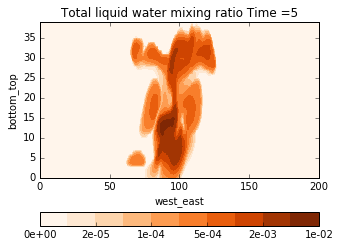

In [10]:
from matplotlib.colors import BoundaryNorm

qliquid=dataset['QRAIN']+dataset['QCLOUD']
qliquid.attrs['long_name'] = "Total liquid water mixing ratio"
qliquid.attrs['units'] = "kg/kg"

itime=5
qliquid_slice = (qliquid.load()
                       .isel(south_north=0,Time=itime,bottom_top=slice(0,40))
                       .squeeze())

levels = [0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3,1e-2]
cmap = plt.get_cmap("Oranges")
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(5., 4.))
ax = fig.add_subplot(111)

cf = ax.contourf(qliquid_slice, 
                 levels=levels, cmap=cmap, norm=norm)
ax.set_xlabel('west_east')
ax.set_ylabel('bottom_top')
ax.set_title(qliquid.attrs['long_name']+' Time ='+str(itime))

cb = plt.colorbar(cf, ax=ax, orientation='horizontal', format="%1.0e")

In [11]:
from ipywidgets import interact

def browse_images(qliquid):
    t = 25
    def plot_qvapor(i):
        qliquid_slice = (qliquid.load()
                           .isel(south_north=0,Time=i,bottom_top=slice(0,40))
                           .squeeze())

        levels = [0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3,1e-2]
        cmap = plt.get_cmap("Oranges")
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        fig = plt.figure(figsize=(5., 4.))
        ax = fig.add_subplot(111)

        cf = ax.contourf(qliquid_slice, 
                         levels=levels, cmap=cmap, norm=norm)
        ax.set_xlabel('west_east')
        ax.set_ylabel('bottom_top')
        ax.set_title(qliquid.attrs['long_name']+' Time ='+str(i))

        cb = plt.colorbar(cf, ax=ax, orientation='horizontal', format="%1.0e")
    
    interact(plot_qvapor, i=(0,t-1))
    

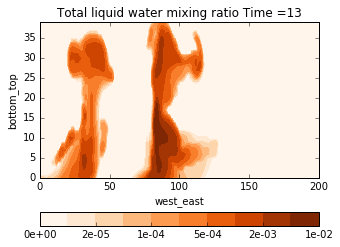

In [12]:
browse_images(qliquid)

As an exercise, add one for vertical velocity: